# Calculating phylogenetic signals

## Environment settings
```sh
# Working Directory
cd Bac2fFeature/scripts/05_phylogenetic_signals
# Output Directory
directories=(
    "../../data/phylogenetic_signals"
)
for dir in "${directories[@]}"; do
  if [ ! -d "$dir" ]; then
    mkdir -p "$dir"
  fi
done
```

## Calculation of phylogenetic signals
```sh
conda activate r_bac2feature
# For continuous traits
Rscript calc_blombergs_K.R
# For categorical traits
Rscript calc_phylod.R
```

In [12]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind
from scipy.optimize import curve_fit
import statsmodels.api as sm

matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.sans-serif'] = ["Arial", "DejaVu Sans", "Lucida Grande", "Verdana"]
matplotlib.rcParams["figure.figsize"] = [4, 3]
matplotlib.rcParams["font.size"] = 10
matplotlib.rcParams["axes.labelcolor"] = "#000000"
matplotlib.rcParams["axes.linewidth"] = 1.0
matplotlib.rcParams["xtick.major.width"] = 1.0
matplotlib.rcParams["ytick.major.width"] = 1.0

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

cmap1 = plt.cm.tab20
cmap2 = plt.cm.Set3

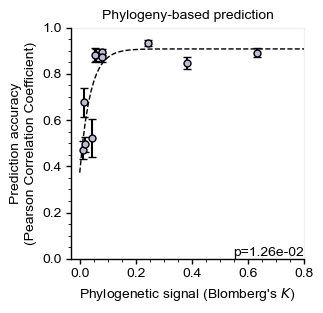

In [13]:
trait = pd.read_csv('../../data/ref_bac2feature/trait_bac2feature.tsv', sep='\t')

# Blomberg's K
blombergs_K = pd.read_csv('../../data/phylogenetic_signals/blombergs_K.tsv', sep='\t')
blombergs_K['trait'] = trait.columns[1:12]
prediction_accuracy = pd.read_csv('../../data/cross_validation/prediction_accuracy_continuous_traits.tsv', sep='\t')

K_vs_acc = pd.merge(blombergs_K, prediction_accuracy, how='inner', on='trait')

# Visualization
fig, ax = plt.subplots(figsize=(3, 3))

x = K_vs_acc["K"]
y = K_vs_acc["phylogeny_mean"]
y_err = K_vs_acc["phylogeny_std"]

ax.errorbar(x, y, yerr = y_err,
            capsize=3, fmt='o', markersize=5,
            ecolor='black', markeredgecolor='black', color=cmap2.colors[2])

def curve_func(x, a, b, c):
    y = a - (a - b) * np.exp(- c * x)
    return y

popt, _ = curve_fit(curve_func, x, y)

X_fitted = np.arange(0, 1.1, 0.01)
Y_fitted = curve_func(X_fitted, *popt)
ax.plot(X_fitted, Y_fitted,
        color='black', linewidth=1, linestyle="dashed")

ax.set_xlabel('Phylogenetic signal (Blomberg\'s $\it{K}$)')
ax.set_ylabel('Prediction accuracy\n(Pearson Correlation Coefficient)')
ax.set_title('Phylogeny-based prediction', fontsize=10)

ax.set_xlim(-0.03, 0.8)
ax.set_ylim(0, 1)
ax.spines['top'].set(alpha=0.1, color='grey')
ax.spines['right'].set(alpha=0.1, color='grey')

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

# Variance: before fitting
bef_y = list(K_vs_acc["phylogeny_mean"])
bef_y_abs = np.abs(bef_y - np.mean(bef_y))
# Variance: after fitting
aff_y = list(y - curve_func(x, *popt))
aff_y_abs = np.abs(aff_y)

p_value = ttest_ind(bef_y_abs, aff_y_abs, equal_var=False, alternative='two-sided')[1]
ax.text(x=0.8, y=0.0, s=f'p={p_value:.2e}', verticalalignment='bottom', horizontalalignment='right')

plt.savefig("../../results/05_phylogenetic_signals/K_vs_acc.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)

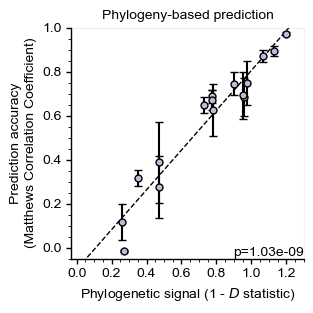

In [14]:
phylod = pd.read_csv('../../data/phylogenetic_signals/phylod.tsv', sep='\t', names=["trait", "D"])
prediction_accuracy = pd.read_csv('../../data/cross_validation/prediction_accuracy_categorical_traits.tsv', sep='\t')

phylod_vs_acc = pd.merge(phylod, prediction_accuracy, how='inner', on='trait')
phylod_vs_acc['-D+1'] = - phylod_vs_acc['D'] + 1

# Visualization
fig, ax = plt.subplots(figsize=(3, 3))

x = phylod_vs_acc["-D+1"]
y = phylod_vs_acc["phylogeny_mean"]
y_err = phylod_vs_acc["phylogeny_std"]

ax.errorbar(x, y, yerr = y_err,
            capsize=3, fmt='o', markersize=5,
            ecolor='black', markeredgecolor='black', color=cmap2.colors[2])

x_fit = phylod_vs_acc["-D+1"].astype(float)
x_fit_const = sm.add_constant(x_fit)
y_fit = phylod_vs_acc["phylogeny_mean"].astype(float)

model = sm.OLS(y_fit, x_fit_const)
res = model.fit()

lim = [-.05, 1.3]
lim_const = sm.add_constant(lim)
lim_fitted = np.array(lim_const) @ np.array(res.params).reshape(-1, 1)
ax.plot(lim, lim_fitted,
        color="black", linewidth=1, linestyle="dashed")

ax.set_xlabel('Phylogenetic signal (1 - $\it{D}$ statistic)')
ax.set_ylabel('Prediction accuracy\n(Matthews Correlation Coefficient)')
ax.set_title('Phylogeny-based prediction', fontsize=10)

ax.set_xlim(-0.03, 1.3)
ax.set_ylim(-0.05, 1)
ax.spines['top'].set(alpha=0.1, color='grey')
ax.spines['right'].set(alpha=0.1, color='grey')

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

p_value = res.f_pvalue
ax.text(x=1.3, y=-0.05, s=f'p={p_value:.2e}', verticalalignment='bottom', horizontalalignment='right')

plt.savefig("../../data/phylogenetic_signals/D_vs_acc.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)